In [ ]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xgboost as xgb
import catboost as cb
import category_encoders as ce

from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, SplineTransformer, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import (
    cross_validate, GridSearchCV
)

from sklearn.ensemble import RandomForestRegressor

from malbecs.modeling import train as tr
from malbecs.modeling.transformers import QuantileFeatureEncoder

seed = 42

final_wine_path = "../../data/final/wine_final.csv"
final_eto_path = "../../data/final/eto_final.csv"
final_meteo_path = "../../data/final/meteo_final.csv"


with open("../../data/final/meteo_features.txt", "r") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")
    wine_cols.remove('produccion')


def score_model(X_test, y_test, y_pred, sup_norm=True):
    if sup_norm:
        y_test = X_test['superficie']*y_test
        y_pred = X_test['superficie']*y_pred

    return tr.rmse_score(y_test, y_pred)
    

In [ ]:
#load all data
data = tr.load_final_data(
    wine_path=final_wine_path,
    eto_path=final_eto_path,
    meteo_path=final_meteo_path
)

In [ ]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [c for c in eto_cols if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]


In [72]:
# meteo_cols
[c for c in percip_cols]

['MeanPrecipAmountLocalDayAvgMonth1',
 'MeanPrecipAmountLocalDayAvgMonth2',
 'MeanPrecipAmountLocalDayAvgMonth3',
 'MeanPrecipAmountLocalDayAvgMonth4',
 'MeanPrecipAmountLocalDayAvgMonth5',
 'MeanPrecipAmountLocalDayAvgMonth6',
 'MeanPrecipAmountLocalDayMaxMonth1',
 'MeanPrecipAmountLocalDayMaxMonth2',
 'MeanPrecipAmountLocalDayMaxMonth3',
 'MeanPrecipAmountLocalDayMaxMonth4',
 'MeanPrecipAmountLocalDayMaxMonth5',
 'MeanPrecipAmountLocalDayMaxMonth6',
 'SumTotalPrecipAmountLocalDayMonth1',
 'SumTotalPrecipAmountLocalDayMonth2',
 'SumTotalPrecipAmountLocalDayMonth3',
 'SumTotalPrecipAmountLocalDayMonth4',
 'SumTotalPrecipAmountLocalDayMonth5',
 'SumTotalPrecipAmountLocalDayMonth6',
 'MeanPrecip',
 'TotalPrecip',
 'StdlPrecip']

In [ ]:
# data prep

data_train = tr.filter_camp(data.copy(), min_camp=16, max_camp=21)

# data_train['produccion'] = data_train['produccion']/data_train['superficie']

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca', 
    'id_zona',
    'id_estacion', 
    'variedad',
    "modo", 
    "tipo",
    "color", 
    "prod_shift1_gt_shift2"
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')
X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)


train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X_train['campaña'], from_camp=19, to_camp=20
)

cv_train = tr.CampKFold(train_idxs, test_idxs)


In [71]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import Lasso, LassoCV

wine_num_cols = [c for c in wine_cols if c not in cat_cols]

model_num_cols = [
    'superficie',
    'prod_shift1',
    'prod_shift2',
    'prod_shift_max',
    'prod_shift_change',
]

model_cat_cols = [
    'id_finca',
    'id_zona',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2"
]

xgb_params = {'colsample_bytree': 0.5, 'learning_rate': 0.01,
              'max_depth': 4, 'n_estimators': 400}


m = make_pipeline( 
    make_column_transformer(
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), model_cat_cols),
        # (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['variedad']),
        # (QuantileFeatureEncoder(col="id_finca"), ['id_finca']),
        (QuantileFeatureEncoder(col="variedad"), ['variedad']),
        (QuantileFeatureEncoder(col="id_zona"), ['id_zona']),
        (KBinsDiscretizer(n_bins=5), ['altitud']),
        (MinMaxScaler(), model_num_cols),
        (StandardScaler(), percip_cols),
        # (StandardScaler(), temp_cols),
        # (StandardScaler(), snow_cols),
        # (StandardScaler(), temp_day_cols),
        # (StandardScaler(), gust_cols),
        remainder='drop'
    ),
    # xgb.XGBRegressor(**xgb_params,random_state=seed)
    RandomForestRegressor(
        random_state=99, 
        n_estimators=200, 
        min_samples_leaf=3, 
        n_jobs=-1, 
        max_features='sqrt',
        max_depth=100,
    )

)

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

print("test: ",res['test_score'])
print("train: ",res['train_score'])

# train-test score
# y_pred = m.fit(X_train, y_train).predict(X_test)
# score_model(X_test, y_test, y_pred, sup_norm=True)

test:  [-5096.88723568 -6787.80118612 -5416.63318865]
train:  [-3950.09880339 -3698.75293947 -3755.6113577 ]


In [65]:
param_grid = {
    # 'xgbregressor__min_child_weight': [1, 5, 10],
    # 'xgbregressor__gamma': [0.5, 1, 1.5, 2, 5],
    # 'xgbregressor__subsample': [0.6, 0.8],
    'xgbregressor__colsample_bytree': [0.5,0.7,0.8],
    'xgbregressor__max_depth': [2, 3, 4],
    'xgbregressor__n_estimators':[200,400,800],
    'xgbregressor__learning_rate':[0.005,0.01,0.05]
}

param_grid = {

    'randomforestregressor__max_features': [0.5, 0.7, 0.8],
    'randomforestregressor__max_depth': [2, 3, 4],
    'randomforestregressor__n_estimators': [200, 400, 800],
    
}

gsm = GridSearchCV(
    m,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=tr.rmse_scorer
)

gsm.fit(X,y)

print(gsm.best_params_)
print(gsm.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'randomforestregressor__max_depth': 4, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__n_estimators': 800}
-6014.780448145048


In [66]:
y_pred = gsm.best_estimator_.fit(X_train, y_train).predict(X_test)
score_model(X_test, y_test, y_pred, sup_norm=False)

5826.2905881080005

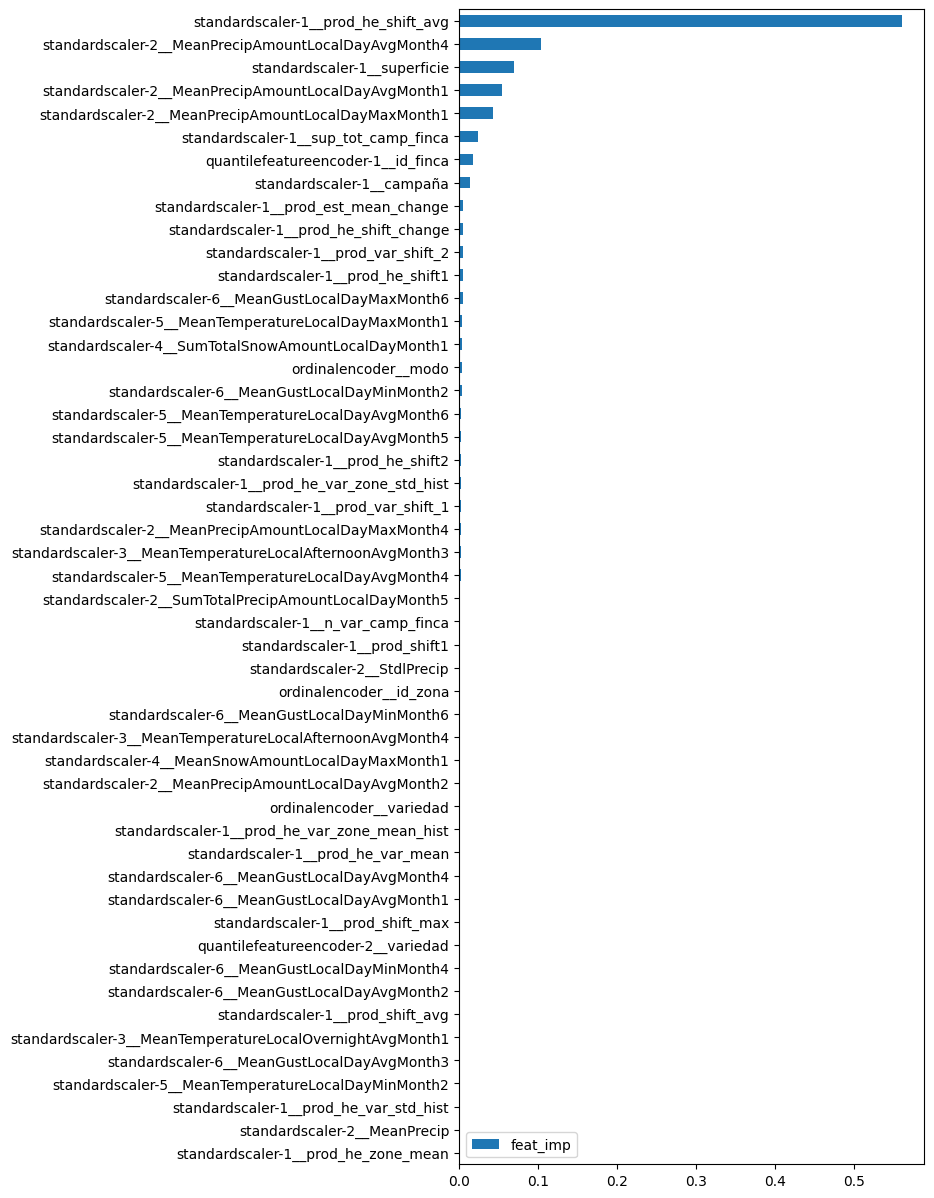

In [12]:
def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


show_feat_imps(
    gsm.best_estimator_[-1].feature_importances_,
    gsm.best_estimator_[:-1].get_feature_names_out(),
)


In [13]:
# def show_feat_imps(feat_imp, feat_names):
#     m.fit(X_train, y_train)
#     pd.DataFrame(
#         m[-1].feature_importances_,
#         index=m[:-1].get_feature_names_out(),
#         columns=["feat_imp"]
#     ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6,15))

In [14]:
# m.fit(X_train, y_train)
# pd.DataFrame(
#     m[-1].coef_,
#     index=m[:-1].get_feature_names_out(),
#     columns=["feat_imp"]
# ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6,15))